# Instance Segmentation

# keywords: MaskRCNN, COCO

### Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [ ]:
%%shell
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

--2021-06-09 14:57:01--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  30.4MB/s    in 1.7s    

2021-06-09 14:57:03 (30.4 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2021-06-09 14:57:03--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-06-09 14:57:04--
Total wall clock time: 2.1s
Downloaded: 1 files, 51M in 1.7s (30.4 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [ ]:
import cv2
import matplotlib.pyplot as plt

img=cv2.cvtColor(cv2.imread('PennFudanPed/PNGImages/FudanPed00001.png'), cv2.COLOR_BGR2RGB)
plt.figure(figsize = (10,10))
plt.imshow(img)

error: ignored

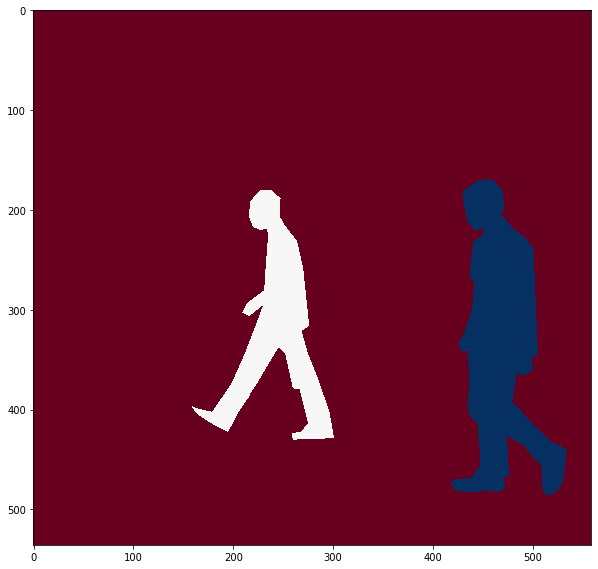

In [ ]:
mask = cv2.imread('PennFudanPed/PedMasks/FudanPed00001_mask.png', cv2.IMREAD_UNCHANGED)

cmap = plt.get_cmap('RdBu', 3)
plt.figure(figsize = (10,10))

plt.imshow(mask, cmap=cmap)

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from pathlib import Path

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(list((root / "PNGImages").glob("*")))

    def __getitem__(self, i):
        # load images ad masks
        img_path = self.imgs[i]
        mask_path = self.root / "PedMasks" / f"{img_path.stem}_mask.png"

        img=cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)

        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, np.newaxis, np.newaxis]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([i])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = PennFudanDataset(Path('PennFudanPed'))
dataset[0]

(array([[[211, 200, 182],
         [210, 199, 181],
         [212, 201, 183],
         ...,
         [143,  96,  78],
         [146,  99,  81],
         [148, 101,  83]],
 
        [[179, 168, 150],
         [173, 162, 144],
         [170, 159, 141],
         ...,
         [126,  79,  61],
         [128,  81,  63],
         [128,  81,  63]],
 
        [[204, 193, 175],
         [194, 183, 165],
         [188, 177, 159],
         ...,
         [130,  83,  65],
         [131,  84,  66],
         [130,  83,  65]],
 
        ...,
 
        [[226, 220, 220],
         [217, 211, 211],
         [211, 205, 205],
         ...,
         [183, 183, 183],
         [184, 184, 184],
         [185, 185, 185]],
 
        [[231, 225, 225],
         [219, 213, 213],
         [210, 204, 204],
         ...,
         [187, 187, 187],
         [187, 187, 187],
         [186, 186, 186]],
 
        [[225, 219, 219],
         [227, 221, 221],
         [215, 209, 209],
         ...,
         [190, 190, 190],
  

In [ ]:
len(dataset)

170

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

We will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)



We will use COCO pretrained model from the torchvision library.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


At first we will need to copy transforms from master branch of torchision repository.

In [ ]:
!git clone https://github.com/pytorch/vision.git

fatal: destination path 'vision' already exists and is not an empty directory.


In [ ]:
!cp vision/references/detection/transforms.py .

In [ ]:
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

Default collate function will group batches in tensors, but in this task we have variable number of labels/detection per image, thus we will need to write our own collate function (this is a function which creates a batch from elements).

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset(Path('PennFudanPed'), get_transform(train=True))
dataset_test = PennFudanDataset(Path('PennFudanPed'), get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-20])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-20:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
data, targets = data_loader.__iter__().__next__()


In [ ]:
targets

({'area': tensor([32264., 29294.]), 'boxes': tensor([[ 14.,  28., 123., 324.],
          [168.,  26., 265., 328.]]), 'image_id': tensor([1]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)},
 {'area': tensor([34080.]),
  'boxes': tensor([[280.,  89., 400., 373.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
      

MaskRCNN model from torchvision is tricky. It behaves differently in train/eval mode:

In [ ]:
model.train()
model(list(image.to(device) for image in data), [{k: v.to(device) for k, v in t.items()} for t in targets])

{'loss_box_reg': tensor(0.1998, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_classifier': tensor(0.7927, device='cuda:0', grad_fn=<NllLossBackward>),
 'loss_mask': tensor(1.8239, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_objectness': tensor(0.0253, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)}

In [ ]:
model.eval()
model(list(image.to(device) for image in data))

[{'boxes': tensor([[ 44.5399, 137.2720, 130.7458, 319.2441],
          [  0.0000, 154.4075, 301.4864, 305.7758],
          [  4.5316, 207.3310, 377.0000, 328.4835],
          [ 74.5795, 282.7793, 377.0000, 327.8512],
          [252.7263,  54.1388, 267.1290,  62.9524],
          [332.6158, 308.0898, 369.3690, 338.0382],
          [275.1007,  40.9770, 325.5513,  68.0817],
          [153.9692, 106.7678, 288.7263, 131.7033],
          [151.8154, 123.5769, 280.6831, 152.7467],
          [197.0207, 302.3475, 373.1183, 331.3649],
          [339.6263,  40.9107, 350.1095,  48.4309],
          [293.8942,  53.8208, 326.1392,  95.3518],
          [223.8328,  52.3153, 241.2133,  60.5613],
          [228.9790,  49.5564, 242.7825,  59.5424],
          [158.3217, 313.7195, 367.5561, 338.3456],
          [260.8555,  60.9540, 304.1772, 116.5109],
          [185.4568,  73.0943, 312.7589, 106.5429],
          [  0.0000, 287.3899, 289.9216, 337.7219],
          [188.2028,  78.9001, 271.8676, 318.7201],
   

You can create similar model yourself by checking `model.training` field in `forward` method.

In [ ]:
model.training

False

In [ ]:
model.train()
model.training

True

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
def train(model, optimizer, dataloader, device):
  model.train()
  for i, (images, targets) in enumerate(dataloader):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    if (i % 5 == 0):
      print(f"batch #{i}, losses: {loss_dict}")

In [ ]:
# let's train it for 10 epochs
num_epochs = 3

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    train(model, optimizer, data_loader, device)
    # update the learning rate
    lr_scheduler.step()


Epoch: 0
batch #0, losses: {'loss_classifier': tensor(0.7889, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.1523, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(1.8876, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_objectness': tensor(0.0074, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)}
batch #5, losses: {'loss_classifier': tensor(0.2708, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.4242, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(0.2175, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_objectness': tensor(0.0248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0122, device='cuda:0', grad_fn=<DivBackward0>)}
batch #10, losses: {'loss_classifier': tensor(0.0498, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_bo

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[1]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

[{'boxes': tensor([[100.5193,  61.0797, 271.9616, 356.0385],
          [331.8628, 132.4415, 371.6828, 208.1180],
          [238.5013, 152.0637, 296.3334, 210.7348]], device='cuda:0'),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

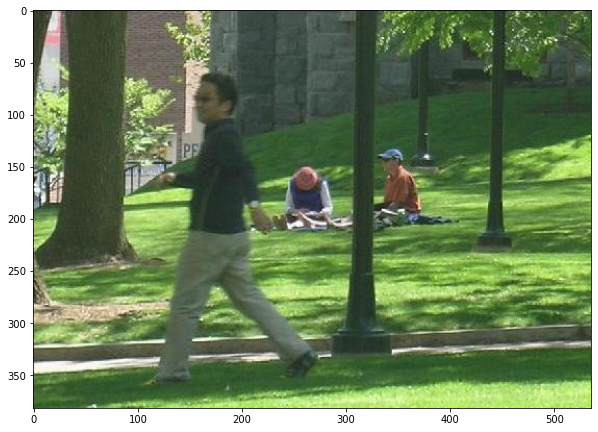

In [ ]:
plt.figure(figsize=((10,10)))
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

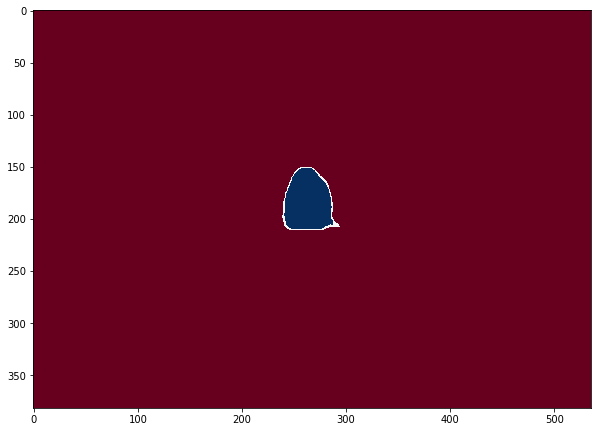

In [ ]:
plt.figure(figsize=((10,10)))

plt.imshow(prediction[0]['masks'][2, 0].mul(255).byte().cpu().numpy(), cmap=cmap)

In [ ]:
!pip install cython

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-jrapoumn
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-jrapoumn
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263904 sha256=35c44e357450b556cbc5fe9025f295b53d108d1e730355bff2ce6e7b7f85dabd
  Stored in directory: /tmp/pip-ephem-wheel-cache-tru1wiiw/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [ ]:
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator

In [ ]:
def test(model, dataloader, device):
    cpu_device = torch.device("cpu")
    model.eval()

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = ["bbox", "segm"]
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in dataloader:
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

In [ ]:
test(model, data_loader_test, device)

creating index...
index created!
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

# Assignment.
1. We fine-tuned COCO pretrained model to segment pedastrians. However, COCO has person class among many others. Test if our fine-tuning give us better results than segmentation with original model. [5]


NOTE: I just recopy all the cells to get the order and structure clear for myself

Task Summary:

- Predict on 20 person dataset using original COCO model
- Use all weights from pre-trained model
- Just get the model, there will be a lot of classes
- But among these classes there will be a human class
- Find out what class corresponds to human
- And to test how good original model gets image
- Question: Did we improve at all by removing the heads?
- The pre-train was already really really good
- Are we better than the pretrained model?

So:
  - 1: Repeat the model exactly present during training in the class
  - 2: Test how good this model is on test dataset
  - 3: Use original COCO model
  - 4: Test how good is on our test dataset with only 'person' class

# GENERAL

In [ ]:
%%shell
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

--2021-06-09 15:17:52--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip.4’

PennFudanPed.zip.4  100%[===================>]  51.23M  29.1MB/s    in 1.8s    

2021-06-09 15:17:54 (29.1 MB/s) - ‘PennFudanPed.zip.4’ saved [53723336/53723336]

--2021-06-09 15:17:54--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-06-09 15:17:54--
Total wall clock time: 2.1s
Downloaded: 1 files, 51M in 1.8s (29.1 MB/s)
Archive:  PennFudanPed.zip
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.utils.data
from pathlib import Path

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import transforms as T

import cv2
import matplotlib.pyplot as plt

import os
import numpy as np
import torch
import torch.utils.data
from pathlib import Path

In [ ]:
cmap = plt.get_cmap('RdBu', 3)

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(list((root / "PNGImages").glob("*")))

    def __getitem__(self, i):
        # load images ad masks
        img_path = self.imgs[i]
        mask_path = self.root / "PedMasks" / f"{img_path.stem}_mask.png"

        img=cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)

        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, np.newaxis, np.newaxis]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([i])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset(Path('PennFudanPed'), get_transform(train=True))
dataset_test = PennFudanDataset(Path('PennFudanPed'), get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-20])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-20:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

# MODEL PRACTICE SESSION

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

model_practice_session = get_instance_segmentation_model(num_classes)
model_practice_session.to(device)

params = [p for p in model_practice_session.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
def train(model, optimizer, dataloader, device):
  model.train()
  for i, (images, targets) in enumerate(dataloader):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    if (i % 5 == 0):
      print(f"batch #{i}, losses: {loss_dict}")

In [ ]:
# let's train it for 10 epochs
num_epochs = 3

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    train(model_practice_session, optimizer, data_loader, device)
    # update the learning rate
    lr_scheduler.step()

Epoch: 0
batch #0, losses: {'loss_classifier': tensor(0.7927, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.1998, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(1.8239, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_objectness': tensor(0.0253, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)}
batch #5, losses: {'loss_classifier': tensor(0.1425, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.1972, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(0.1944, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_objectness': tensor(0.0114, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)}
batch #10, losses: {'loss_classifier': tensor(0.0729, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_bo

In [ ]:
def test(model, dataloader, device):
    cpu_device = torch.device("cpu")
    model.eval()

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = ["bbox", "segm"]
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in dataloader:
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()


In [ ]:
test(model_practice_session, data_loader_test, device)

creating index...
index created!
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

In [ ]:
!rm -r checkpoints

In [ ]:
!mkdir checkpoints

In [ ]:
 # Save training checkpoints for practice session model
 checkpoint_dir = "checkpoints"
 torch.save(model_practice_session.state_dict(), f"{checkpoint_dir}/epoch_{epoch}.pth")

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model_practice_session.eval()
with torch.no_grad():
    prediction_practice_session = model_practice_session([img.to(device)])

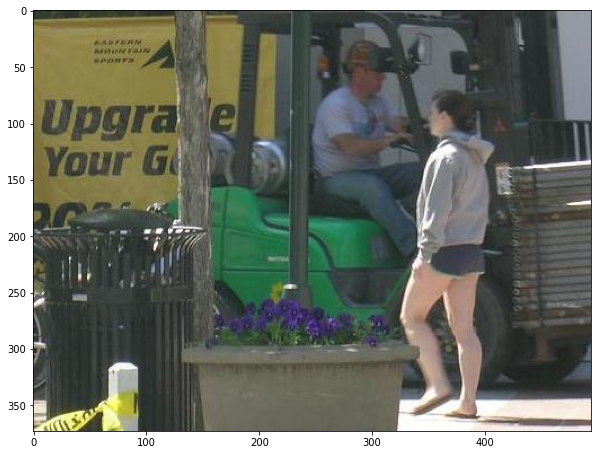

In [ ]:
plt.figure(figsize=((10,10)))
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())

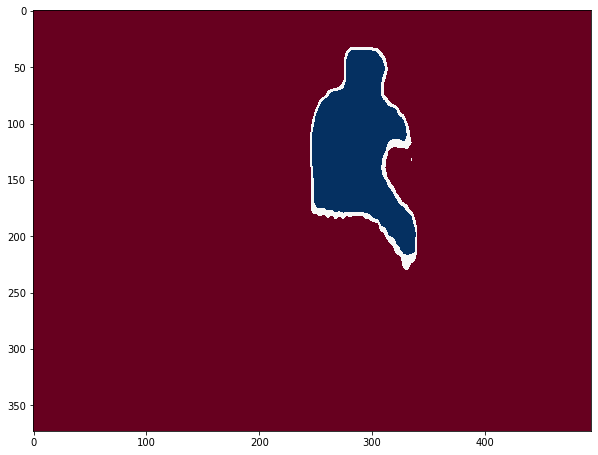

In [ ]:
plt.figure(figsize=((10,10)))
plt.imshow(prediction_practice_session[0]['masks'][1, 0].mul(255).byte().cpu().numpy(), cmap=cmap)

# UNCHANGED COCO MODEL 

## _Notes_

- No training, just testing straight away

- Model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

- Get rid of all non-person predictions (consider them background).

- Just create a new model which have rcnn inside it. In forward function call rcnn.forward and apply the post processing I talked before (drop the non-person predictions, change label for person).


- In postprocess function you filter out all non-person bboxes and changes person bbox level to 2

- 99% of time you just inherit all your models from nn.Module class


##_nn.Module_

https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module


##_Inheritance of maskrnn_resnet50_fpn_

https://discuss.pytorch.org/t/where-is-the-forward-function-of-the-mask-rcnn/99256


###_Location of the forward function in nn.Module_


This is the definition in the nn.Module. Basically all it does is raising “Unimplemented” exception. It’s expected that you override it for all the modules you inherit.


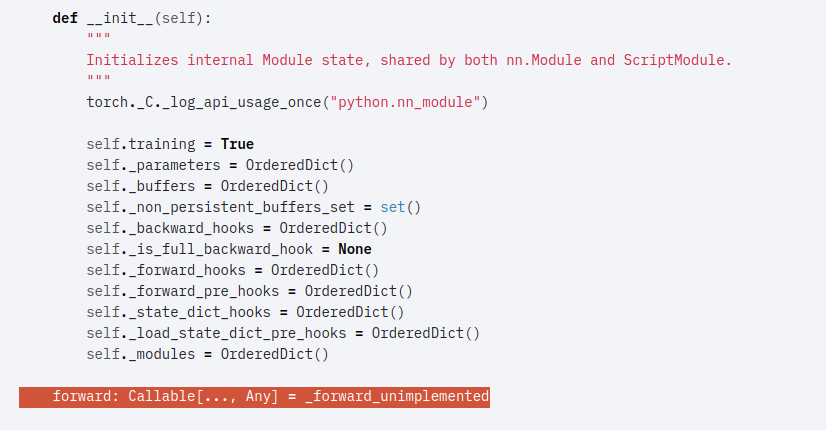

## Sample code

```
class MyRCNN(nn.Module): 
  def __init__(...): 
    self.model = pretrained_rcnn_model()
    ...

  def forward(*args): 
    data = self.model(*args)
    return postprocess_data_dict(data)
```

## Execution

In [ ]:
model_COCO = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)

In [ ]:
model_COCO.forward

<bound method GeneralizedRCNN.forward of MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2

In [ ]:
test(model_COCO, data_loader_test, device)

creating index...
index created!
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model_COCO.eval()
with torch.no_grad():
    prediction = model_COCO([img.to(device)])

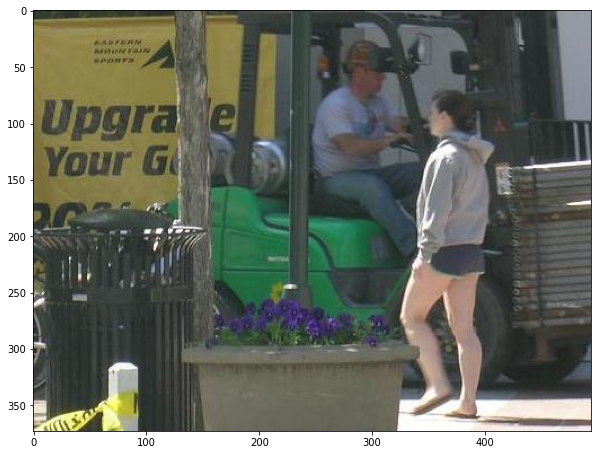

In [ ]:
plt.figure(figsize=((10,10)))
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())

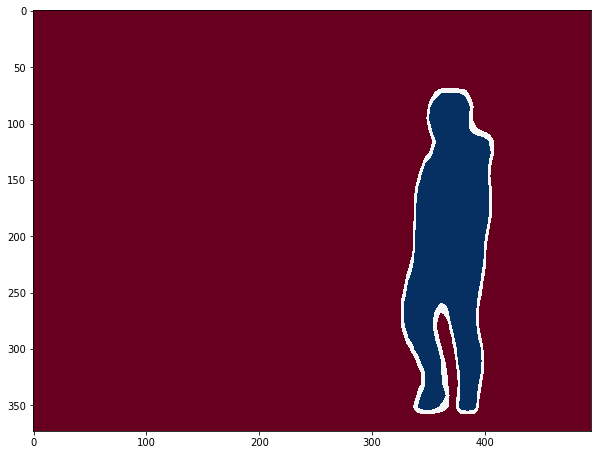

In [ ]:
plt.figure(figsize=((10,10)))
plt.imshow(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy(), cmap=cmap)

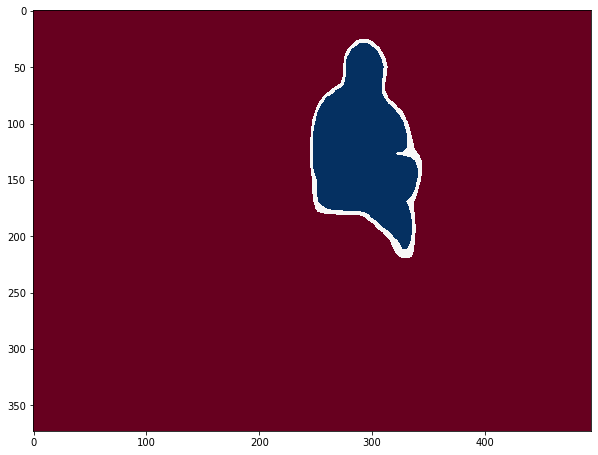

In [ ]:
plt.figure(figsize=((10,10)))
plt.imshow(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy(), cmap=cmap)

In [ ]:
while True:
  pass